# Predict Occupancy for an office zone
### Import packages

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgbm
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "svg"

### Import rawdata

In [2]:
path = r'C:\Users\Jacky\Jupyter Projects\Occupancy_Prediction\Data'
df = pd.read_excel(path+r'\Alldata.xlsx').drop(['index'], axis=1)

### Preprocess the data
Resample for smooth data

In [3]:
# Variables for resample.mean
data_mean = pd.DataFrame(
    # Data
    dict(
        T_z=df['T_z'].values,
        RH=df['Humid'].values,
        CO2=df['CO2'].values,
        T_o=df['T_OA'].values
    ), 
    # Time Index
    df['Time'])
data_mean = data_mean.resample('10min').mean().round(1)
data_mean.reset_index(inplace=True)

# Variables for resample.max
data_max = pd.DataFrame(
    # Data
    dict(Occ=df['Occ'].values), 
    # Time Index
    df['Time'])
data_max = data_max.resample('10min').max()
data_max.reset_index(inplace=True)

# Variables for resample.asfreq
data_freq = pd.DataFrame(
    # Data
    dict(HRV=df['HRVspeed'].values), 
    # Time Index
    df['Time'])
data_freq = data_freq.resample('10min').asfreq()
data_freq.reset_index(inplace=True)

# Merge data
data_resample = pd.merge(data_mean, data_max, how="outer", sort=True)
data_resample = pd.merge(data_resample, data_freq, how="outer", sort=True)

# Set Time variables: [Day of Week, Hour of Day]
data_resample['DoW'] = [i.weekday()+1 for i in data_resample['Time']]
data_resample['HoD'] = [(i.hour+i.minute/60) for i in data_resample['Time']]

# Show the resample data
data_resample

,Time,T_z,RH,CO2,T_o,Occ,HRV,DoW,HoD
0,2020-07-01 00:00:00,30.2,87.5,474.9,28.5,0,0.0,3,0.000000
1,2020-07-01 00:10:00,30.2,88.0,479.4,28.4,0,0.0,3,0.166667
2,2020-07-01 00:20:00,30.2,88.5,489.4,28.4,0,0.0,3,0.333333
3,2020-07-01 00:30:00,30.3,88.6,499.0,28.3,0,0.0,3,0.500000
4,2020-07-01 00:40:00,30.3,88.7,495.1,28.3,0,0.0,3,0.666667
...,...,...,...,...,...,...,...,...,...
13243,2020-09-30 23:10:00,26.5,92.9,488.4,22.6,0,0.0,3,23.166667
13244,2020-09-30 23:20:00,26.5,92.9,477.0,22.6,0,0.0,3,23.333333
13245,2020-09-30 23:30:00,26.5,92.8,484.0,22.5,0,0.0,3,23.500000
13246,2020-09-30 23:40:00,26.5,92.7,480.8,22.4,0,0.0,3,23.666667


### Create features for Occpancy prediction

In [4]:
# CO2 Features
data_resample['CO2_movingavg_30'] = data_resample['CO2'].rolling(3).mean()
data_resample['CO2_movingdif_30'] = data_resample['CO2']-data_resample['CO2_movingavg_30']
data_resample['CO2_movingavg_60'] = data_resample['CO2'].rolling(6).mean()
data_resample['CO2_movingdif_60'] = data_resample['CO2']-data_resample['CO2_movingavg_60']
data_resample['CO2_movingavg_90'] = data_resample['CO2'].rolling(9).mean()
data_resample['CO2_movingdif_90'] = data_resample['CO2']-data_resample['CO2_movingavg_90']

# Shift as lag features
data_resample['CO2_movingavg_30'] = data_resample['CO2_movingavg_30'].shift(6)
data_resample['CO2_movingdif_30'] = data_resample['CO2_movingdif_30'].shift(6)
data_resample['CO2_movingavg_60'] = data_resample['CO2_movingavg_60'].shift(6)
data_resample['CO2_movingdif_60'] = data_resample['CO2_movingdif_60'].shift(6)
data_resample['CO2_movingavg_90'] = data_resample['CO2_movingavg_90'].shift(6)
data_resample['CO2_movingdif_90'] = data_resample['CO2_movingdif_90'].shift(6)
data_resample['HRVspeed_60'] = data_resample['HRV'].shift(6)
data_resample['CO2_60'] = data_resample['CO2'].shift(6)
data_resample.dropna(inplace=True)

### Pickup the features & the target

In [5]:
# df_Feature
df_Feature = pd.concat([
    data_resample['DoW'], data_resample['HoD'], 
    data_resample['HRVspeed_60'], data_resample['CO2_60'],
    data_resample['CO2_movingavg_30'], data_resample['CO2_movingdif_30'],
    data_resample['CO2_movingavg_60'], data_resample['CO2_movingdif_60'],
    data_resample['CO2_movingavg_90'], data_resample['CO2_movingdif_90']
    ],axis=1)

# df_Target
df_Target = data_resample['Occ']

### Set the model & predict the target

In [6]:
# Data split for train & test
X_train,X_test,y_train,y_test = train_test_split(
    df_Feature,
    df_Target,
    test_size=0.2,
    random_state=1,
    shuffle=False)

# LGBM settings
lgbmodel = lgbm.LGBMRegressor(nthread=3, num_iterations = 50)

[LightGBM] [Warning] num_threads is set with n_jobs=-1, nthread=3 will be ignored. Current value: num_threads=-1
r2 score test: 0.6526834465902884
r2 score train: 0.8290201209453285
r2 score all_data: 0.7957919600111595


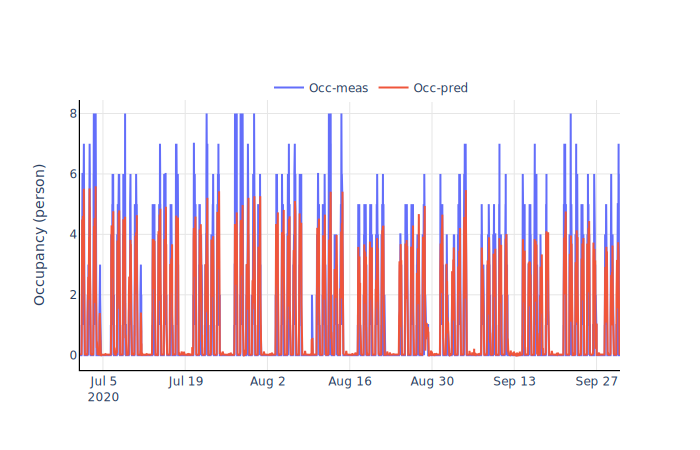

In [7]:
# Train the model
lgbmodel.fit(X_train, y_train)

# r square values of the model
print('r2 score test:', r2_score(y_test, lgbmodel.predict(X_test)))
print('r2 score train:', r2_score(y_train, lgbmodel.predict(X_train)))
print('r2 score all_data:', r2_score(df_Target, lgbmodel.predict(df_Feature)))

# Merge the rawdata and prediction
df_Predict = pd.DataFrame(lgbmodel.predict(df_Feature), index=df_Target.index)
df_Plot = pd.concat([data_resample['Time'], df_Target, df_Predict], axis=1)
df_Plot.columns = ['Time', 'real', 'predict']

# Plot measured and predicted data
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        name = 'Occ-meas',
        x = df_Plot['Time'],
        y = df_Plot['real']
    ))
fig.add_trace(
    go.Scatter(
        name = 'Occ-pred',
        x = df_Plot['Time'],
        y = df_Plot['predict']
    ))
fig.update_xaxes(
    showline=True, linewidth=1.2, linecolor='black',
    showticklabels=True, showgrid=True, gridcolor="rgb(230, 230, 230)"
)
fig.update_yaxes(
    title="Occupancy (person)",
    showline=True, linewidth=1.2, linecolor='black',
    showticklabels=True, showgrid=True, gridcolor="rgb(230, 230, 230)"
)    
fig.update_layout(
    plot_bgcolor="white",
    legend=dict(
        orientation="h",
        x=0.35,
        y=1.1
    ))
fig.show()

The predicted occupancy schedule can be used to forcast the cooling demand or CO<sub>2</sub> concentration in the next hour.